In [1]:
import os
import ast
import json
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import albumentations
import pydicom as dicom
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
base_config = {
    "EFFB7": {"IMG_HEIGH": 600, "IMG_WIDTH": 600, "BATCH_SIZE": 16, "SEED": 42},
    "CLASS": {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3},
}

In [3]:
file_json = open("/app/_data/base_config.json", "w")
json.dump(base_config, file_json)
file_json.close()

In [4]:
list_bad = [
    "f00655c68e05.jpg",
    "b6f989cfd190.jpg",
    "5cae48f87eb1.jpg",
    "f5af0ed4c2db.jpg",
    "57675376af04.jpg",
    "0c22dc834dea.jpg",
]

In [5]:
train = pd.read_csv("/app/_data/train.csv")

In [6]:
# os.mkdir("/app/_data/train_npy/")

In [7]:
train["class_id"] = train["class"].replace(base_config['CLASS'])

In [8]:
class Aug:
    def augment_image(img):
        h = img.shape[0]
        w = img.shape[1]
        transform = albumentations.Compose(
            [
                albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
                albumentations.OneOf(
                    [
                        albumentations.MotionBlur((3, 5)),
                        albumentations.MedianBlur(blur_limit=5),
                        albumentations.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                        albumentations.Blur(blur_limit=(3, 5)),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.GaussNoise(var_limit=[10, 20], mean=1),
                        albumentations.ImageCompression(
                            quality_lower=70, quality_upper=100, compression_type=1
                        ),
                        albumentations.MultiplicativeNoise(
                            multiplier=(0.95, 1.05), per_channel=False, elementwise=True
                        ),
                        albumentations.Downscale(
                            scale_min=0.8, scale_max=0.99, interpolation=4
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.RandomBrightnessContrast(
                            brightness_limit=0.2,
                            contrast_limit=0.2,
                            brightness_by_max=True,
                        ),
                        albumentations.augmentations.transforms.Sharpen(
                            alpha=(0.05, 0.15), lightness=(0.5, 1.0), p=1
                        ),
                        albumentations.augmentations.transforms.RandomToneCurve(
                            scale=0.15
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.RandomSizedCrop(
                    min_max_height=(0.9 * h, 0.9 * w),
                    height=h,
                    width=w,
                    w2h_ratio=1.0,
                    interpolation=0,
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.OpticalDistortion(
                            distort_limit=0.1,
                            shift_limit=0.1,
                            border_mode=0,
                        ),
                        albumentations.ElasticTransform(
                            alpha=2.0,
                            sigma=2.0,
                            alpha_affine=2.0,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.GridDistortion(
                            num_steps=5,
                            distort_limit=0.3,
                            interpolation=0,
                            border_mode=0,
                        ),
                    ],
                    p=0.3,
                ),
                albumentations.OneOf(
                    [
                        albumentations.Rotate(
                            limit=(-10, 10), interpolation=0, border_mode=0
                        ),
                        albumentations.ShiftScaleRotate(
                            shift_limit=0.1,
                            scale_limit=0.1,
                            rotate_limit=10,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.augmentations.crops.transforms.CropAndPad(
                            px=None,
                            percent=(-0.15, 0.1),
                            pad_mode=0,
                            pad_cval=0,
                            pad_cval_mask=0,
                            keep_size=True,
                            sample_independently=True,
                            interpolation=1,
                        ),
                        albumentations.RandomSizedCrop(
                            min_max_height=(0.9 * h, 0.9 * w),
                            height=h,
                            width=w,
                            w2h_ratio=1.0,
                            interpolation=0,
                        ),
                    ],
                    p=0.3,
                ),
            ]
        )

        return transform(image=img)["image"]

In [10]:
train[['id_image', 'boxes', 'StudyInstanceUID', 'image', 'class', 'path',
       'modality', 'PatientSex', 'BodyPartExamined',
       'PhotometricInterpretation', 'width', 'height',
       'n_bbox', 'class_id']]

,id_image,boxes,StudyInstanceUID,image,class,path,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,n_bbox,class_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,000a312787f2.dcm,typical,/app/_data/train/5776db0cec75/81456c9c5423/000...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1
1,000c3a3f293f_image,NaN,ff0879eb20ed,000c3a3f293f.dcm,negative,/app/_data/train/ff0879eb20ed/d8a644cc4f93/000...,CR,M,CHEST,MONOCHROME2,2832.0,2320.0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,0012ff7358bc.dcm,typical,/app/_data/train/9d514ce429a7/22897cd1daa0/001...,DX,F,PORT CHEST,MONOCHROME2,3056.0,2544.0,2,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,001398f4ff4f.dcm,atypical,/app/_data/train/28dddc8559b2/4d47bc042ee6/001...,CR,F,CHEST,MONOCHROME1,4280.0,3520.0,1,3
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,001bd15d1891.dcm,typical,/app/_data/train/dfd9fdd85a3e/49170afa4f27/001...,DX,M,CHEST,MONOCHROME1,3408.0,2800.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,7e6c68462e06,ffcc6edd9445.dcm,negative,/app/_data/train/7e6c68462e06/98011bca5fd2/ffc...,CR,F,CHEST,MONOCHROME2,3480.0,4240.0,0,0
6330,ffd91a2c4ca0_image,NaN,8332bdaddb6e,ffd91a2c4ca0.dcm,negative,/app/_data/train/8332bdaddb6e/f346cda52da0/ffd...,DX,F,CHEST,MONOCHROME1,3408.0,2800.0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",7eed9af03814,ffd9b6cf2961.dcm,typical,/app/_data/train/7eed9af03814/668a64e3a5fa/ffd...,DX,M,TORAX,MONOCHROME2,3050.0,2388.0,3,1
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",a0cb0b96fb3d,ffdc682f7680.dcm,typical,/app/_data/train/a0cb0b96fb3d/ccf363aa080f/ffd...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1


In [ ]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        batch_size,
        img_width,
        img_heigh,
        seed,
        prepared_img_path,
        shuffle=False,
        augment=False,
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_heigh = img_heigh
        self.seed = seed
        self.prepared_img_path = prepared_img_path
        self._shuffle = shuffle
        self.augment = augment

    if not os.path.exists(self.prepared_img_path):
        os.mkdir(self.prepared_img_path)

    def on_epoch_start(self):
        if self._shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def make_img(self, img_name):
        try:
            img = np.load(self.prepared_img_path + img_name + ".npy")
        except:
            img = tf.io.read_file("/app/_data/jpg/" + img_name + ".jpg")
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(
                img,
                (img_heigh, img_width),
            )
            img = tf.cast(img, tf.uint8)
            np.save(self.prepared_img_path + img_name, img)
        return img

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"][:-4]
        label = self.df.loc[ix, "class_id"]
        modality = self.df.loc[ix, "modality"]
        PatientSex = self.df.loc[ix, "PatientSex"]
        body_part_id = self.df.loc[ix, "BodyPartExamined"]
        img = self.make_img(img_name)

        if self.augment:
            img = Aug.augment_image(img)

In [156]:
train.sample().columns

Index(['id_image', 'boxes', 'label', 'StudyInstanceUID', 'image', 'id_study',
       'Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance', 'class', 'path',
       'modality', 'PatientSex', 'BodyPartExamined',
       'PhotometricInterpretation', 'Rows', 'Columns', 'width', 'height',
       'n_bbox', 'class_id'],
      dtype='object')

In [129]:
gen = Generator(
    df=train,
    batch_size=base_config["BATCH_SIZE"],
    seed=base_config["SEED"],
    img_width=base_config["IMG_WIDTH"],
    img_heigh=base_config["IMG_HEIGH"],
    prepared_img_path="/app/_data/train_npy/",
)

In [130]:
a = gen.make_img(train.loc[0, "path"], train.loc[0, "PhotometricInterpretation"])

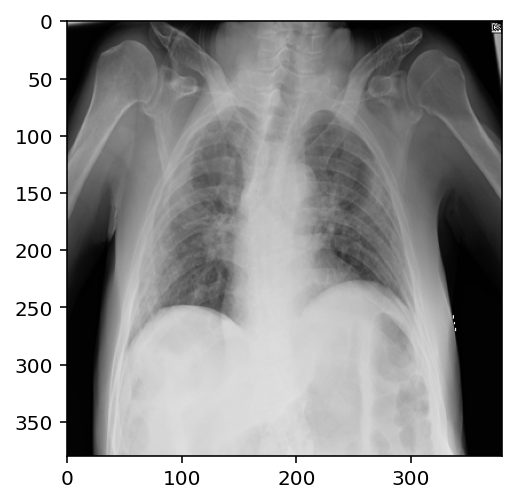

In [132]:
plt.imshow(a)

In [131]:
for i in tqdm(range(1000)):
    a = gen.make_img(train.loc[0, "path"], train.loc[0, "PhotometricInterpretation"])

100%|██████████| 1000/1000 [00:00<00:00, 1161.99it/s]


In [25]:
a = np.random.rand(5, 7)

In [26]:
a

array([[5.83327309e-01, 1.08852003e-01, 9.93844545e-01, 8.85960535e-01,
        6.61390362e-01, 4.04758408e-04, 3.86942852e-01],
       [2.03756494e-01, 8.82540845e-01, 6.08032250e-01, 2.94908513e-01,
        1.32557066e-01, 2.56821423e-01, 9.95448121e-01],
       [6.87534320e-01, 8.55904613e-01, 3.74975130e-01, 5.19127177e-01,
        6.80853096e-01, 6.94116552e-03, 8.36863774e-01],
       [6.57252539e-01, 2.39909372e-01, 4.66084877e-01, 6.86976973e-01,
        3.02923834e-01, 8.13984461e-01, 1.64067991e-01],
       [5.95928867e-01, 3.69697725e-01, 4.99190463e-01, 5.58405387e-01,
        7.13605959e-01, 3.78091586e-01, 1.74895507e-01]])

In [29]:
np.stack([a, a, a], axis=-1).shape

(5, 7, 3)